# Project: Wrangling WeRateDogs Twitter Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Assesing Data</a></li>
<li><a href="#clean">Cleaning</a>
    <ul>
        <li><a href="#quality">Quality</a></li>
        <li><a href="#tidy">Tidiness</a></li>
    </ul>
 </li>
<li><a href="#analyze">Analyzing and Visualizing Data</a></li>
</ul>


<a id='intro'></a>

## Introduction

WeRateDogs is a Twitter account that rates user submitted photos, usually with humorous content. It has a unique rating system that comprises of a numerator and denominator. The numerator is usually greater than that the denominator. The main object of this project will be gather, wrangle and retrieve some insights of the WeRateDogs account that will be retrieved from different sources. 

In [575]:
import pandas as pd
import requests
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import configparser
from tweepy import OAuthHandler
from timeit import default_timer as timer

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


<a id='gather'></a>
## Data Gathering

Download the WeRateDogs *[Twitter archive](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)* by clicking on the download link.

Use the `pd.read_csv` method to load the data into a Pandas Dataframe

In [10]:
archives_df = pd.read_csv('twitter-archive-enhanced.csv')

Use the Requests library to download the tweet image prediction file (image_predictions.tsv)

In [4]:
#Make a new folder to hold downloaded image-predictions tsv file

folder = 'Predictions'
if not os.path.exists(folder):
    os.makedirs(folder)

In [6]:
#Download file using the requests library 

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [7]:
#write the contents of the response into a file in the Predictions folder

with open(os.path.join(folder, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)


Confirm the contents of the `Predictions` folder:

In [12]:
#lists all the folders/lists of specified directory

os.listdir('Predictions')

['image-predictions.tsv']

Now that we have confirmed that the image-predictions file has been successfully created, we can proceed with reading its contents and loading them into a dataframe

In [13]:
#Read Data from the Image Predictions file into a dataframe

predictions_df = pd.read_csv('Predictions\image-predictions.tsv', sep='\t')

Since I dont have the required elevated access to Twitter's API

Once you've downloaded the tweet-json text file move it into your working directory. 

In [14]:
credentials = configparser.ConfigParser()
credentials.read('config.ini')

['config.ini']

In [273]:

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions

consumer_key = credentials['WeRateDogs']['APIKey']
consumer_secret = credentials['WeRateDogs']['API_Key_Secret']
access_token = credentials['WeRateDogs']['ACCESS_Token']
access_secret = credentials['WeRateDogs']['ACCESS_Token_Secret']

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archives_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            print(str(count) + ": " + str(tweet_id))
        except tweepy.errors.Forbidden as e:
        #Silently handle the expected HTTP ERROR 403: UNAUTHORIZED_CLIENT_APPLICATION authorization error:
            print(e)
            print('\n')
            break
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print('{:.4f} secs'.format(end - start))

#Checks if dict is populated, if yes,  prints contents
if fails_dict:
    print(fails_dict)

403 Forbidden
453 - You currently have Essential access which includes access to Twitter API v2 endpoints only. If you need access to this endpoint, you’ll need to apply for Elevated access via the Developer Portal. You can learn more here: https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-leve


0.6650 secs


Since we dont have access to twitter's API, we are going to manually download additional data to supplement our datasets from this **[link](https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt)**

In [393]:
#Create an empty list that will be used to hold the dictionary objects read from the Json txt file

json_list = []

Read JSON Data from the `tweet-json.txt` Text File

In [394]:
'''
 Use glob module to loop through and find text files in your working directory
 Employ a for loop together with .readline() to read lines in the text file
 Parse the String returned by the readline method into a Python dictionary with the json.loads method
 Create a python dictionary that will be loaded into the empty Json_list list
 Confirm if dictionary is present in list, if not append to list, else skip. This will ensure we dont append duplicates
'''

for tweet_file in glob.glob('*.txt'):
    with open(tweet_file, encoding='utf-8') as file:
        for line in file:
            txt_obj = file.readline()
            tweet_obj = json.loads(txt_obj)
            tweet_dict = {'tweet_id' : tweet_obj['id'], 'created_at' : tweet_obj['created_at'], 
                          'retweet_count' : tweet_obj['retweet_count'],'favorite_count' : tweet_obj['favorite_count'],
                          'followers_count' : tweet_obj['user']['followers_count']}
            if tweet_dict not in json_list:
                json_list.append(tweet_dict)

In [395]:
#glimpse of the first 2 items in the list

json_list[0:2]

[{'tweet_id': 892177421306343426,
  'created_at': 'Tue Aug 01 00:17:27 +0000 2017',
  'retweet_count': 6514,
  'favorite_count': 33819,
  'followers_count': 3200889},
 {'tweet_id': 891689557279858688,
  'created_at': 'Sun Jul 30 15:58:51 +0000 2017',
  'retweet_count': 8964,
  'favorite_count': 42908,
  'followers_count': 3200889}]

Confirm that they are of the Python *`dict`* datatype  

In [396]:
#Type of the zero-indexed object in the json_list list

assert(type(json_list[0]) == dict)

Optionally, we can use the *`isinstance`* function that checks and returns *`True`* if the specified object is a subclass or an instance of the indicated type

In [397]:
#Type of last-indexed object in the json_list

isinstance(json_list[-1], dict)

True

Use the Pandas' *`from_dict`* method to construct a dataframe from our dictionaries in the json_list list. 

In [398]:

additional_tweets_df = pd.DataFrame.from_dict(json_list)

Check if the tweet_ids in the newly created additional_tweets_df are in the archives dataframe.   

In [532]:
#use for loop to assert presence of subset

for tweetID in list(additional_tweets_df.tweet_id):
    assert tweetID in list(archives_df.tweet_id)

<a id='assess'></a>
## Assessing Data

### Quality issues
###### archive_df Table
1. duplicate tweets inform of retweets

2. `tweet_id` is an integer instead of a string object

3. `timestamp` is a string object 

4. `in_reply_to_user_id`, `in_reply_to_status_id`, `retweeted_status_timestamp`, `retweeted_status_id` and `retweeted_status_user_id` columns have null values 

5. The source of the tweet is embedded in html tags in the `source` column 

6. missing `names` represented as None 

7. `names` extracted incorrectly in some cases i.e 'a', 'the', 'an' among many others 

8. `rating_denominator` is greater than or less than 10 in some cases 

###### additional_tweets_df Table: 
1. `created_at` column in the additional_tweets_df is a duplicated of the timestamp column in archives_df 
2. `tweet_id` is an integer instead of a string object
###### predictions_df Table
1. `tweet_id` is an integer instead of a string object



### Tidiness Issues

1. The *doggo*, *floofer*, *pupper* and *puppo* identifiers should unpivoted into a single column
2. The three tables should be merged into a single unit.

 

In [401]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row', None)

let's make a visual inspection of our first dataframe

##### archives_df Table

In [402]:
archives_df.sample(5)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1347  704364645503647744                    NaN                  NaN   
1960  673363615379013632                    NaN                  NaN   
1156  724771698126512129                    NaN                  NaN   
1157  724405726123311104                    NaN                  NaN   
1637  684195085588783105                    NaN                  NaN   

                      timestamp  \
1347  2016-02-29 17:56:32 +0000   
1960  2015-12-06 04:49:31 +0000   
1156  2016-04-26 01:26:53 +0000   
1157  2016-04-25 01:12:38 +0000   
1637  2016-01-05 02:09:54 +0000   

                                                                                  source  \
1347  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1960  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1156  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1157  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1637  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                          text  \
1347                 Say hello to Bisquick. He's a Beneplop Cumbersnug. Even smiles when wet. 12/10 I'd steal Bisquick https://t.co/5zX5XD3i6K   
1960  This little pupper can't wait for Christmas. He's pretending to be a present. S'cute. 11/10 twenty more days 🎁🎄🐶 https://t.co/m8r9rbcgX4   
1156                                                                    Nothin better than a doggo and a sunset. 11/10 https://t.co/JlFqOhrHEs   
1157                This is Ashleigh. She's having Coachella withdrawals. Didn't even go tho. 10/10 stay strong pupper https://t.co/nRUaKWnJfH   
1637                                                                      This is Tino. He really likes corndogs. 9/10 https://t.co/cUxGtnBfc2   

      retweeted_status_id  retweeted_status_user_id  \
1347                  NaN                       NaN   
1960                  NaN                       NaN   
1156                  NaN                       NaN   
1157                  NaN                       NaN   
1637                  NaN                       NaN   

     retweeted_status_timestamp  \
1347                        NaN   
1960                        NaN   
1156                        NaN   
1157                        NaN   
1637                        NaN   

                                                                                                                                                                                                                                                        expanded_urls  \
1347                                                                                                                                  https://twitter.com/dog_rates/status/704364645503647744/photo/1,https://twitter.com/dog_rates/status/704364645503647744/photo/1   
1960                                                                                                                                                                                                  https://twitter.com/dog_rates/status/673363615379013632/photo/1   
1156  https://twitter.com/dog_rates/status/724771698126512129/photo/1,https://twitter.com/dog_rates/status/724771698126512129/photo/1,https://twitter.com/dog_rates/status/724771698126512129/photo/1,https://twitter.com/dog_rates/status/724771698126512129/photo/1   
1157                                                                                                                                                                                                  https://twitter.com/dog_rates/status/724405726123311104/photo/1   
1637                                                                       

In [403]:
archives_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [404]:
archives_df.shape

(2356, 17)

In [405]:
archives_df.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

Check for duplicates in the *`tweet_id`* column

In [406]:
archives_df['tweet_id'].duplicated().sum()

0

There are **no** duplicates in the archives_df dataframe. 

In [407]:
archives_df.duplicated().sum()

0

Let us examine the *name* column

In [408]:
archives_df.name.value_counts()

None              745
a                  55
Charlie            12
Cooper             11
Lucy               11
Oliver             11
Tucker             10
Penny              10
Lola               10
Winston             9
Bo                  9
Sadie               8
the                 8
Daisy               7
Buddy               7
Toby                7
an                  7
Bailey              7
Leo                 6
Oscar               6
Stanley             6
Rusty               6
Bella               6
Dave                6
Jack                6
Koda                6
Scout               6
Jax                 6
Milo                6
Louis               5
Phil                5
Sammy               5
Gus                 5
Chester             5
Alfie               5
Sunny               5
Bentley             5
very                5
Oakley              5
Finn                5
George              5
Larry               5
Clarence            4
Loki                4
Walter              4
Reggie    

In [409]:
archives_df[archives_df.name == 'a'].sample(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1737  679530280114372609                    NaN                  NaN   
2153  669661792646373376                    NaN                  NaN   
2314  666701168228331520                    NaN                  NaN   

                      timestamp  \
1737  2015-12-23 05:13:38 +0000   
2153  2015-11-25 23:39:47 +0000   
2314  2015-11-17 19:35:19 +0000   

                                                                                  source  \
1737  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2153  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2314  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                              text  \
1737  Guys this really needs to stop. We've been over this way too many times. This is a giraffe. We only rate dogs.. 7/10 https://t.co/yavgkHYPOC   
2153   This is a brave dog. Excellent free climber. Trying to get closer to God. Not very loyal though. Doesn't bark. 5/10 https://t.co/ODnILTr4QM   
2314   This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly https://t.co/uQbZJM2DQB   

      retweeted_status_id  retweeted_status_user_id  \
1737                  NaN                       NaN   
2153                  NaN                       NaN   
2314                  NaN                       NaN   

     retweeted_status_timestamp  \
1737                        NaN   
2153                        NaN   
2314                        NaN   

                                                        expanded_urls  \
1737  https://twitter.com/dog_rates/status/679530280114372609/photo/1   
2153  https://twitter.com/dog_rates/status/669661792646373376/photo/1   
2314  https://twitter.com/dog_rates/status/666701168228331520/photo/1   

      rating_numerator  rating_denominator name doggo floofer pupper puppo  
1737                 7                  10    a  None    None   None  None  
2153                 5                  10    a  None    None   None  None  
2314                 8                  10    a  None    None   None  None

In [410]:
archives_df[archives_df.name == 'an'].sample(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
759   778396591732486144                    NaN                  NaN   
2204  668636665813057536                    NaN                  NaN   
2333  666337882303524864                    NaN                  NaN   

                      timestamp  \
759   2016-09-21 00:53:04 +0000   
2204  2015-11-23 03:46:18 +0000   
2333  2015-11-16 19:31:45 +0000   

                                                                                  source  \
759   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2204  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2333  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                              text  \
759   RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR   
2204   This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg   
2333   This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL   

      retweeted_status_id  retweeted_status_user_id  \
759          7.030419e+17              4.196984e+09   
2204                  NaN                       NaN   
2333                  NaN                       NaN   

     retweeted_status_timestamp  \
759   2016-02-26 02:20:37 +0000   
2204                        NaN   
2333                        NaN   

                                                                                                                        expanded_urls  \
759   https://twitter.com/dog_rates/status/703041949650034688/photo/1,https://twitter.com/dog_rates/status/703041949650034688/photo/1   
2204                                                                  https://twitter.com/dog_rates/status/668636665813057536/photo/1   
2333                                                                  https://twitter.com/dog_rates/status/666337882303524864/photo/1   

      rating_numerator  rating_denominator name doggo floofer pupper puppo  
759                 10                  10   an  None    None   None  None  
2204                10                  10   an  None    None   None  None  
2333                 9                  10   an  None    None   None  None

Let's count the number of null value in the *in_reply_to_status_id* column

In [411]:
sum(archives_df.in_reply_to_status_id.isnull())

2278

Number of null values in the in_reply_to_user_id

In [412]:
sum(archives_df.in_reply_to_user_id.isnull())

2278

Number of null values in the *retweeted_status_id*

In [413]:
sum(archives_df.retweeted_status_id.isnull())

2175

Number of null values in the *retweeted_status_user_id*

In [414]:
sum(archives_df.retweeted_status_user_id.isnull())

2175

No. of unique values in the *rating_denominator* column with their respective counts

In [415]:
archives_df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

There are several entries with a rating of more than 10

##### Predictions Table

In [416]:
#retrieve a sanple of 10 rows from dataframe

predictions_df.sample(10)

tweet_id  \
505   675891555769696257   
1820  834458053273591808   
920   701952816642965504   
1113  724405726123311104   
1853  840696689258311684   
1404  769695466921623552   
1574  795464331001561088   
435   674394782723014656   
1744  822872901745569793   
1087  718939241951195136   

                                                                                      jpg_url  \
505                                           https://pbs.twimg.com/media/CWE_x33UwAEE3no.jpg   
1820                                          https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg   
920                                           https://pbs.twimg.com/media/Cb3WXMUUMAIuzL8.jpg   
1113                                          https://pbs.twimg.com/media/Cg2bKLAWwAA0WEm.jpg   
1853                                          https://pbs.twimg.com/media/C6rBLenU0AAr8MN.jpg   
1404                                          https://pbs.twimg.com/media/Cq6B8V6XYAA1T1R.jpg   
1574  https://pbs.twimg.com/ext_tw_video_thumb/795464066940764160/pu/img/jPkMMQXdydb7CqFX.jpg   
435                                           https://pbs.twimg.com/media/CVvueeeWwAUcQLR.jpg   
1744                                          https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg   
1087                                          https://pbs.twimg.com/media/CfovbK4WIAAkTn3.jpg   

      img_num                   p1   p1_conf  p1_dog  \
505         1    Italian_greyhound  0.305637    True   
1820        1  Rhodesian_ridgeback  0.468619    True   
920         1           toy_poodle  0.331707    True   
1113        1     golden_retriever  0.240695    True   
1853        1             web_site  0.841768   False   
1404        1                  pug  0.407117    True   
1574        1     golden_retriever  0.193082    True   
435         1        toilet_tissue  0.134983   False   
1744        1     Lakeland_terrier  0.196015    True   
1087        1             Pembroke  0.766327    True   

                            p2   p2_conf  p2_dog                           p3  \
505                    whippet  0.232057    True                   Great_Dane   
1820                   whippet  0.177531    True                      redbone   
920           miniature_poodle  0.272485    True              standard_poodle   
1113            cocker_spaniel  0.202444    True                  feather_boa   
1853                      rule  0.007087   False                     envelope   
1404                    muzzle  0.165638   False                       kuvasz   
1574  Chesapeake_Bay_retriever  0.157927    True  soft-coated_wheaten_terrier   
435               mosquito_net  0.133247   False             Lakeland_terrier   
1744        Labrador_retriever  0.160329    True                Irish_terrier   
1087                  Cardigan  0.222126    True                toilet_tissue   

       p3_conf  p3_dog  
505   0.117806    True  
1820  0.106552    True  
920   0.169415    True  
1113  0.159348   False  
1853  0.006820   False  
1404  0.045837    True  
1574  0.124684    True  
435   0.109099    True  
1744  0.069126    True  
1087  0.006757   False

In [417]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [418]:
#retrieve descriptive statistics

predictions_df.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [419]:
#Check for duplicates

predictions_df.tweet_id.duplicated().sum()

0

There are **no** duplicates in the predictions dataFrame

##### additional_tweets_df

In [420]:
additional_tweets_df.sample(10)

tweet_id                      created_at  retweet_count  \
829   683030066213818368  Fri Jan 01 21:00:32 +0000 2016            832   
1077  669583744538451968  Wed Nov 25 18:29:39 +0000 2015           1017   
19    884562892145688576  Tue Jul 11 00:00:02 +0000 2017           5100   
1154  666781792255496192  Wed Nov 18 00:55:42 +0000 2015            211   
529   741303864243200000  Fri Jun 10 16:19:48 +0000 2016           3650   
780   688179443353796608  Sat Jan 16 02:02:19 +0000 2016            669   
173   831670449226514432  Wed Feb 15 01:04:21 +0000 2017           2059   
220   819588359383371776  Thu Jan 12 16:54:26 +0000 2017           2271   
1101  668633411083464705  Mon Nov 23 03:33:22 +0000 2015           1788   
85    858843525470990336  Mon May 01 00:40:27 +0000 2017           3771   

      favorite_count  followers_count  
829             2370          3200952  
1077            1587          3201011  
19             24765          3200890  
1154             404          3201018  
529             9631          3200943  
780             2328          3200951  
173            11469          3200892  
220            10606          3200894  
1101            3024          3201014  
85             16304          3200891

In [421]:
additional_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1177 non-null   int64 
 1   created_at       1177 non-null   object
 2   retweet_count    1177 non-null   int64 
 3   favorite_count   1177 non-null   int64 
 4   followers_count  1177 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 46.1+ KB


In [422]:
#retrieve descriptive stats

additional_tweets_df.describe()

tweet_id  retweet_count  favorite_count  followers_count
count  1.177000e+03    1177.000000     1177.000000     1.177000e+03
mean   7.426493e+17    3107.338997     7901.181818     3.200942e+06
std    6.851760e+16    5458.476288    11536.383916     4.432643e+01
min    6.660209e+17       2.000000        0.000000     3.200802e+06
25%    6.783968e+17     613.000000     1339.000000     3.200898e+06
50%    7.193678e+17    1460.000000     3553.000000     3.200945e+06
75%    7.992971e+17    3628.000000     9872.000000     3.200953e+06
max    8.921774e+17   79515.000000   131075.000000     3.201018e+06

In [423]:
#check for duplicates

additional_tweets_df.duplicated().sum()

0

The range for retweet_count, favourite_count and followers_count columns from **min** and **max** rows are whole numbers   


Let's check for duplicate columns in our 3 dataframes

In [424]:
column_series = pd.Series(list(archives_df) + list(additional_tweets_df) + list(predictions_df))
column_series[column_series.duplicated()]


17    tweet_id
22    tweet_id
dtype: object

We will use the duplicated column to join our dataframes

<a id='clean'></a>
## Cleaning Data


# Make copies of original pieces of data

In [611]:
archives_clean = archives_df.copy()
predictions_clean = predictions_df.copy()
additional_clean = additional_tweets_df.copy()

<a id='quality'></a>
### Quality issues


### Issue #1: archives_df - duplicate tweets inform of retweets

#### Define:
* Delete retweets that can be identified with rows that have a value in *retweeted_status_id* column

#### Code

In [612]:
#filter rows with values in retweeted_status_id column

archives_clean[archives_clean['retweeted_status_id'].notnull()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19    888202515573088257                    NaN                  NaN   
32    886054160059072513                    NaN                  NaN   
36    885311592912609280                    NaN                  NaN   
68    879130579576475649                    NaN                  NaN   
73    878404777348136964                    NaN                  NaN   
74    878316110768087041                    NaN                  NaN   
78    877611172832227328                    NaN                  NaN   
91    874434818259525634                    NaN                  NaN   
95    873697596434513921                    NaN                  NaN   
97    873337748698140672                    NaN                  NaN   
101   872668790621863937                    NaN                  NaN   
109   871166179821445120                    NaN                  NaN   
118   869988702071779329                    NaN                  NaN   
124   868639477480148993                    NaN                  NaN   
130   867072653475098625                    NaN                  NaN   
132   866816280283807744                    NaN                  NaN   
137   866094527597207552                    NaN                  NaN   
146   863471782782697472                    NaN                  NaN   
155   861769973181624320                    NaN                  NaN   
159   860981674716409858                    NaN                  NaN   
160   860924035999428608                    NaN                  NaN   
165   860177593139703809                    NaN                  NaN   
171   858860390427611136                    NaN                  NaN   
180   857062103051644929                    NaN                  NaN   
182   856602993587888130                    NaN                  NaN   
185   856330835276025856                    NaN                  NaN   
194   855245323840757760                    NaN                  NaN   
195   855138241867124737                    NaN                  NaN   
204   852936405516943360                    NaN                  NaN   
211   851953902622658560                    NaN                  NaN   
212   851861385021730816                    NaN                  NaN   
222   849668094696017920                    NaN                  NaN   
230   847978865427394560                    NaN                  NaN   
231   847971574464610304                    NaN                  NaN   
247   845459076796616705                    NaN                  NaN   
250   845098359547420673                    NaN                  NaN   
260   842892208864923648                    NaN                  NaN   
266   841833993020538882                    NaN                  NaN   
272   840761248237133825                    NaN                  NaN   
273   840728873075638272                    NaN                  NaN   
281   839290600511926273                    NaN                  NaN   
285   838916489579200512                    NaN                  NaN   
286   838831947270979586                    NaN                  NaN   
289   838201503651401729                    NaN                  NaN   
298   837012587749474308                    NaN                  NaN   
302   836648853927522308                    NaN                  NaN   
303   836397794269200385                    NaN                  NaN   
307   835685285446955009                    NaN                  NaN   
309   835536468978302976                    NaN                  NaN   
310   835309094223372289                    NaN                  NaN   
319   834477809192075265                    NaN                  NaN   
327   833732339549220864                    NaN                  NaN   
332   832769181346996225                    NaN                  NaN   
340   832215909146226688                    NaN                  NaN   
341   832215726631055365                    NaN         

In [613]:
#create a new df that exxludes the filtered rows

archives_clean = archives_clean[archives_clean['retweeted_status_id'].isnull()]

## Test

In [614]:
#ensure that the count of rows with retweeted_status_id(retweets) is zero

assert(archives_clean['retweeted_status_id'].notnull().sum() == 0)

### Issue #2: tweet_id is an integer instead of a string object in all 3 dataframes

#### Define
* Change the datatype of tweet_id from an integer to a String

#### Code

In [615]:
#use astype method to convert to desired datatype

archives_clean['tweet_id'] = archives_clean['tweet_id'].astype('str')
additional_clean['tweet_id'] = additional_clean['tweet_id'].astype('str')
predictions_clean['tweet_id'] = predictions_clean['tweet_id'].astype('str')

#### Test: 

In [616]:
#confirm that each tweet_id is of class object

assert(archives_clean['tweet_id'].dtype == 'O')
assert(additional_clean['tweet_id'].dtype == 'O')
assert(predictions_clean['tweet_id'].dtype == 'O')

### Issue #3: archives_df - timestamp is a string object 

In [617]:
#Retrieve a sample of the timestamp column

archives_clean.timestamp.sample(1)

1660    2016-01-02 00:14:32 +0000
Name: timestamp, dtype: object

#### Define

* Convert string to a datetime object

#### Code 

In [618]:
# use to_datetime function to convert str to a pandas datetime object 

archives_clean['timestamp'] = pd.to_datetime(archives_clean.timestamp)

#### Test

In [619]:
#confirm that the resulting column is of datetime - UTC timezone datatype

assert(archives_clean['timestamp'].dtype == 'datetime64[ns, UTC]')

### Issue #4: archives_df - in_reply_to_user_id, in_reply_to_status_id, retweeted_status_timestamp, retweeted_status_id and retweeted_status_user_id columns have null values 

#### Define
* Delete indicated columns from dataframe

#### Code

In [620]:
archives_clean.sample(3)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2116  670427002554466305                    NaN                  NaN   
1169  720785406564900865                    NaN                  NaN   
1050  743210557239623680                    NaN                  NaN   

                     timestamp  \
2116 2015-11-28 02:20:27+00:00   
1169 2016-04-15 01:26:47+00:00   
1050 2016-06-15 22:36:19+00:00   

                                                                                  source  \
2116  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1169  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1050  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                             text  \
2116  This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo   
1169                                     This is Archie. He hears everything you say. Doesn't matter where you are. 12/10 https://t.co/0l4I8famYp   
1050  Meet Kayla, an underground poker legend. Players lose on purpose hoping she'll let them pet her. 10/10 strategic af https://t.co/EkLku795aO   

      retweeted_status_id  retweeted_status_user_id  \
2116                  NaN                       NaN   
1169                  NaN                       NaN   
1050                  NaN                       NaN   

     retweeted_status_timestamp  \
2116                        NaN   
1169                        NaN   
1050                        NaN   

                                                        expanded_urls  \
2116  https://twitter.com/dog_rates/status/670427002554466305/photo/1   
1169  https://twitter.com/dog_rates/status/720785406564900865/photo/1   
1050  https://twitter.com/dog_rates/status/743210557239623680/photo/1   

      rating_numerator  rating_denominator    name doggo floofer pupper puppo  
2116                 9                  10       a  None    None   None  None  
1169                12                  10  Archie  None    None   None  None  
1050                10                  10   Kayla  None    None   None  None

In [621]:
#List of columns to be dropped

to_be_deleted = ['in_reply_to_user_id', 'in_reply_to_status_id', 
                  'retweeted_status_timestamp', 'retweeted_status_id', 
                  'retweeted_status_user_id']

In [622]:
archives_clean = archives_clean.drop(columns=to_be_deleted)

#### Test

In [623]:
#checks if any of the columns in the new df are in to_be_deleted list
#Returns ''Specified columns were all deleted'' if specified columns were deleted

def check_columns():
    for column in archives_clean.columns:
        if column in to_be_deleted:
            return ('{} was not deleted'.format(column))
        return('Specified columns were all deleted')
check_columns()

'Specified columns were all deleted'

### Issue #5 archives_df:  The source of the tweet  is embedded in html tags in the source column 

#### Define
* Retrieve the source of the tweet from the string object

#### Code

In [624]:
'''
Split the string using '>' and use indexing to pick one-indexed obejct
split the resulting object on a whitespace and pick the last item
strip whitespace from the string
finally srip the closing anchor tag from the str

'''

archives_clean['source'] = archives_clean['source'].apply(lambda x: x.split('>')[1].split()[-1].strip().strip('</a'))

#### Test 

In [625]:
#Count the number of unique items

archives_clean['source'].value_counts()

iPhone       2042
Scene          91
Client         31
TweetDeck      11
Name: source, dtype: int64

In [626]:
#Check for unique items in source column

archives_clean['source'].unique()

array(['iPhone', 'Client', 'Scene', 'TweetDeck'], dtype=object)

We've successfully stripped away the HTML tag and remained with clean sources of tweets *'iPhone', 'Client', 'Scene', 'TweetDeck'* 

### Issue #6 archives_df:  missing name represented as None

#### Define
* Replace None string entries in the name column with a meaningful descriptor (No Name)

#### Code

In [627]:
# replace every instance of the word None with 'No Name'

archives_clean['name'] = archives_clean['name'].replace('None', 'No_Name')

#### Test 

In [628]:
#confirm that None is not the name column

assert None not in archives_clean['name'].unique()

### Issue #7 archives_df: some names were extracted incorrectly

### Define
* Replace incorrectly extracted names with 'incorrect_name'

In [629]:
#Count the total number of unique names in the archives_clean dataframe:

len(list(archives_clean.name.unique()))

956

Visualize unique items in the name column and try to decipher if there is a pattern in the incorrectly extracted names 

In [630]:
archives_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'No_Name',
       'Jax', 'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart',
       'Oliver', 'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such',
       'Canela', 'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo',
       'Maisey', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy',
       'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti',
       'Goose', 'Nugget', 'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody',
       'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter',
       'Cooper', 'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn',
       'Zooey', 'D

A vigilant walk-through the list of names displayed above will reveal that all proper nouns are always capitalized. It will be safe to assume that the few instances of words like `such`, `a`,`quite`, `not`, `incredibly`  which are all in lower case are incorrectly extracted names. Let's put that assumption to test 

In [631]:
#filter all lower case names and return unique words

lower_case = archives_clean[archives_clean.name.str.islower()].name.unique()
print(lower_case)

['such' 'a' 'quite' 'not' 'one' 'incredibly' 'very' 'my' 'his' 'an'
 'actually' 'just' 'getting' 'mad' 'this' 'unacceptable' 'all' 'old'
 'infuriating' 'the' 'by' 'officially' 'life' 'light' 'space']


In [632]:
#Count of each lower case word

archives_clean[archives_clean.name.str.islower()].name.value_counts()

a               55
the              8
an               6
one              4
very             4
quite            3
just             3
getting          2
not              2
actually         2
old              1
light            1
life             1
officially       1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
mad              1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64

In [633]:
#replace values in inidicated list with indicated value

archives_clean['name'] = archives_clean['name'].replace(lower_case, 'incorrect_name')

#### Test

In [634]:
#Loop through lower_case elements and confirm that they are not in name column:

for name in lower_case:
    assert name not in list(archives_clean['name'].unique())

### Issue #8 archives_df - *rating_denominator* is greater than or less than 10 in some cases 

#### Define
* Replace all values that are not equal to 10 in the rating_denominator with 10

#### Code

Check for instances where the value of the denominator is less than 10

In [635]:
archives_clean[archives_clean['rating_denominator'] < 10]

tweet_id                 timestamp  source  \
313   835246439529840640 2017-02-24 21:54:03+00:00  iPhone   
516   810984652412424192 2016-12-19 23:06:23+00:00  iPhone   
2335  666287406224695296 2015-11-16 16:11:11+00:00  iPhone   

                                                                                                                                                                           text  \
313                                                                          @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho   
516   Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   
2335                                   This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv   

                                                                                            expanded_urls  \
313                                                                                                   NaN   
516   https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1   
2335                                      https://twitter.com/dog_rates/status/666287406224695296/photo/1   

      rating_numerator  rating_denominator            name doggo floofer  \
313                960                   0         No_Name  None    None   
516                 24                   7             Sam  None    None   
2335                 1                   2  incorrect_name  None    None   

     pupper puppo  
313    None  None  
516    None  None  
2335   None  None

Since there is no discernable pattern in rows where the value is less than 10, we will have to clean the denominator manualy

In [636]:
archives_clean.loc[archives_clean['tweet_id'] == '835246439529840640', 'rating_denominator'] = 10

In [637]:
archives_clean.loc[archives_clean['tweet_id'] == '810984652412424192', 'rating_denominator'] = np.nan

In [638]:
archives_clean.loc[archives_clean['tweet_id'] == '666287406224695296', 'rating_denominator'] = 10

Let's check cases where the denominator is higher than 10

In [639]:
#Filter Text rating_numerator and rating_denominator columns where the rating_denominator is greater that 10

archives_clean.loc[archives_clean['rating_denominator'] > 10,['tweet_id','text', 'rating_numerator','rating_denominator']]

tweet_id  \
342   832088576586297345   
433   820690176645140481   
902   758467244762497024   
1068  740373189193256964   
1120  731156023742988288   
1165  722974582966214656   
1202  716439118184652801   
1228  713900603437621249   
1254  710658690886586372   
1274  709198395643068416   
1351  704054845121142784   
1433  697463031882764288   
1598  686035780142297088   
1634  684225744407494656   
1635  684222868335505415   
1662  682962037429899265   
1663  682808988178739200   
1779  677716515794329600   
1843  675853064436391936   

                                                                                                                                                    text  \
342                                                                                                             @docmisterio account started on 11/15/15   
433                                                  The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   
902                                                                       Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE   
1068        After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ   
1120                           Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv   
1165                                                                                    Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a   
1202                               This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq   
1228                                                       Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1   
1254                                        Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12   
1274  From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK   
1351                                                                  Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa   
1433                                                        Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ   
1598            Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating   
1634                      Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3   
1635        Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55   
1662         This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5   
1663         I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible   
1779                                                                              IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq   
1843                                         Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw   

      rating_numerator  rating_denominator  
342                 11                15.0  
433                 84                70.0  
902                165               150.0  
1068                 9                11.0  
1120               204               170.0  
1165                 4                20.0  
1202               

A quick observation from the filtered rows is that for cases where the denominator is greater than 10, in most cases, the text description refers to a group of dogs. These will be left intact and cleaning will be done on erronous entries 

In [640]:
#dog - @docmisterio

archives_clean.loc[archives_clean['tweet_id'] == '832088576586297345', 'rating_denominator'] = np.nan

In [641]:
#dog -Bretagne

archives_clean.loc[archives_clean['tweet_id'] == '740373189193256964', 'rating_denominator'] = 10

In [642]:
#dog - Bluebert

archives_clean.loc[archives_clean['tweet_id'] == '716439118184652801', 'rating_denominator'] = 10

In [643]:
#dog - Darell

archives_clean.loc[archives_clean['tweet_id'] == '682962037429899265', 'rating_denominator'] = 10

#### Test

In [680]:
archives_clean.rating_denominator.unique()

array([ 10.,  nan,  70., 150., 170.,  20.,  90.,  80.,  50.,  40., 130.,
       110.,  16., 120.])

In [681]:
#Test for values greater than 10 and the nan in rating _denominator

for num in archives_clean.rating_denominator:
    assert ((num >= 10) or np.isnan(num))

### Issue #9.  created_at column in the additional_tweets_df is a duplicate of the timestamp column in archives_df

#### Define
* Drop the `created at` column in additional_tweets_df because it is already present in the archives_df column

#### Code

In [647]:
#use drop method

additional_clean = additional_clean.drop(columns='created_at')

####  Test

In [682]:
assert 'created_at' not in additional_clean.columns

<a id='tidy'></a>
### Tidiness 

### Issue #1 The doggo, floofer, pupper and puppo identifiers should unpivoted into a single column

#### Define
* Reshape the doggo, floofer, pupper and puppo into a single column

#### Code


In [649]:

archives_clean_1 = pd.melt(archives_clean, value_name='category', var_name='dog_category', id_vars=['tweet_id', 'timestamp',
                                                            'source', 'text', 'expanded_urls', 
                                                            'rating_denominator','rating_numerator', 
                                                            'name'])

In [650]:
##Dataframe/filter where the value_name category is NOT None

archives_clean_1 = archives_clean_1[archives_clean_1.category != 'None']

In [651]:
#Drop the var_name dog_category column as it wont be need

archives_clean_1.drop(columns='dog_category', inplace=True)

In [652]:
#Check for duplicates

archives_clean_1.duplicated().sum()

0

In [653]:
#confirm the unique items in the Category column

archives_clean_1.category.unique()

array(['doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

Create a second dataframe that excludes the `tweet_ids` in the dataframe above.  

In [654]:
archives_clean_2 = pd.melt(archives_clean, value_name='category', var_name='dog_category', id_vars=['tweet_id', 'timestamp',
                                                            'source', 'text', 'expanded_urls', 
                                                            'rating_denominator','rating_numerator', 
                                                            'name'])

In [655]:
#Filter rows that have none value in the Category column 

archives_clean_2 = archives_clean_2[archives_clean_2.category == 'None']

Drop the `dog_category` column from the dataframe so that we can be able to drop duplicate rows

In [656]:
archives_clean_2.drop(columns='dog_category', inplace=True)

In [657]:
#Drop duplicated rows

archives_clean_2.drop_duplicates(inplace=True)

In [658]:
#Drop rows that are present in archives_clean_1 

archives_clean_2 = archives_clean_2[~archives_clean_2.tweet_id.isin(list(archives_clean_1.tweet_id))]

Concat the two dataframes

In [659]:
#Append archives_clean_2 to archives_clean_1

archives_melted = pd.concat([archives_clean_1, archives_clean_2])

##### Test

In [ ]:
archives_melted.




Combine all the dataframes into a single table

In [660]:
#Concat all the the 3 dataframes along the y-axis

twitter_archive_master = pd.concat([archives_melted, predictions_df, additional_tweets_df], axis=1 )

In [661]:
#twitter_archive_master.reset_index(inplace=True)

## Storing Data

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [662]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyzing and Visualizing Data

##### Questions to investigate

1. Which day of the week that most of the tweets were sent out?
2. How do tweets that were sent out in the morning compare to tweets sent out in the afternoon?
3. what is the most common dog name in the dataset?

In [663]:
#Summary stats of the combined dataframe

twitter_archive_master.describe()

rating_denominator  rating_numerator      tweet_id      img_num  \
count         2185.000000       2187.000000  2.075000e+03  2075.000000   
mean            10.478719         13.204390  7.384514e+17     1.203855   
std              6.944813         47.594984  6.785203e+16     0.561875   
min             10.000000          0.000000  6.660209e+17     1.000000   
25%             10.000000         10.000000  6.764835e+17     1.000000   
50%             10.000000         11.000000  7.119988e+17     1.000000   
75%             10.000000         12.000000  7.932034e+17     1.000000   
max            170.000000       1776.000000  8.924206e+17     4.000000   

           p1_conf       p2_conf       p3_conf      tweet_id  retweet_count  \
count  2075.000000  2.075000e+03  2.075000e+03  1.177000e+03    1177.000000   
mean      0.594548  1.345886e-01  6.032417e-02  7.426493e+17    3107.338997   
std       0.271174  1.006657e-01  5.090593e-02  6.851760e+16    5458.476288   
min       0.044333  1.011300e-08  1.740170e-10  6.660209e+17       2.000000   
25%       0.364412  5.388625e-02  1.622240e-02  6.783968e+17     613.000000   
50%       0.588230  1.181810e-01  4.944380e-02  7.193678e+17    1460.000000   
75%       0.843855  1.955655e-01  9.180755e-02  7.992971e+17    3628.000000   
max       1.000000  4.880140e-01  2.734190e-01  8.921774e+17   79515.000000   

       favorite_count  followers_count  
count     1177.000000     1.177000e+03  
mean      7901.181818     3.200942e+06  
std      11536.383916     4.432643e+01  
min          0.000000     3.200802e+06  
25%       1339.000000     3.200898e+06  
50%       3553.000000     3.200945e+06  
75%       9872.000000     3.200953e+06  
max     131075.000000     3.201018e+06

##### Research Question 1.  Which day of the week that most of the tweets were sent out?

We'll retrieve the day of the week from the timestamp column and use it to create a new column

In [664]:
# convert timestamp column to day of week name using the day_name method 

twitter_archive_master['dayofweek'] = twitter_archive_master['timestamp'].dt.day_name()

In [665]:
#change the datatype of column to categorical

twitter_archive_master['dayofweek'].astype('category')


9       Wednesday
40         Sunday
89         Friday
97         Sunday
98       Saturday
108       Tuesday
149        Monday
165      Saturday
172        Monday
206       Tuesday
213        Friday
255     Wednesday
268      Thursday
272       Tuesday
279      Saturday
286      Thursday
288      Thursday
289     Wednesday
295       Tuesday
304     Wednesday
305     Wednesday
313        Sunday
324      Thursday
325     Wednesday
328       Tuesday
330        Monday
355     Wednesday
357       Tuesday
360        Monday
367        Friday
373     Wednesday
374     Wednesday
382      Saturday
403     Wednesday
407        Monday
413        Sunday
415        Sunday
442        Monday
467        Friday
474       Tuesday
475       Tuesday
481      Saturday
482        Friday
495     Wednesday
502        Monday
561      Thursday
567       Tuesday
585        Monday
588      Saturday
591        Friday
593      Thursday
603        Sunday
629       Tuesday
631        Monday
653      Saturday
674       

In [666]:
#list of unique weekday names

days = twitter_archive_master['dayofweek'].unique()

In [667]:
#retrieve weekday counts

counts = twitter_archive_master['dayofweek'].value_counts()

In [668]:
counts

Monday       359
Tuesday      328
Wednesday    322
Friday       307
Thursday     307
Saturday     287
Sunday       277
Name: dayofweek, dtype: int64

In [669]:
#display the highest count:
    
counts.max()

359

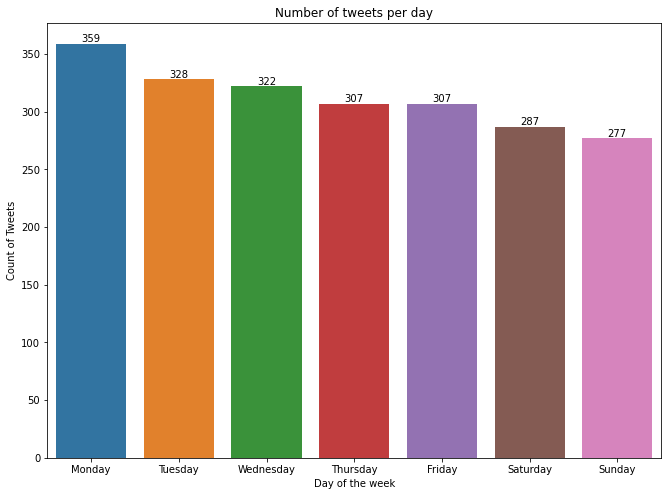

In [670]:
plt.figure(figsize = (11,8))

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

daybar = sns.countplot(x=twitter_archive_master['dayofweek'], order=ordered_days)

for bar in daybar.containers:
    daybar.bar_label(bar)
   
daybar.set(title='Number of tweets per day',
          ylabel='Count of Tweets',
          xlabel='Day of the week');

###### Insight 1:
The day with the most number of tweets is Monday

##### Research Question 2. How do tweets that were sent out in the morning compare to tweets sent out in the afternoon?

In [671]:
#group timestamp column into 'Morning' and 'Afternoon'

time_diff = twitter_archive_master['favorite_count' ].groupby(twitter_archive_master['timestamp'].dt.hour <=12).sum().rename(
    {True: 'Morning', False: 'Afternoon'})

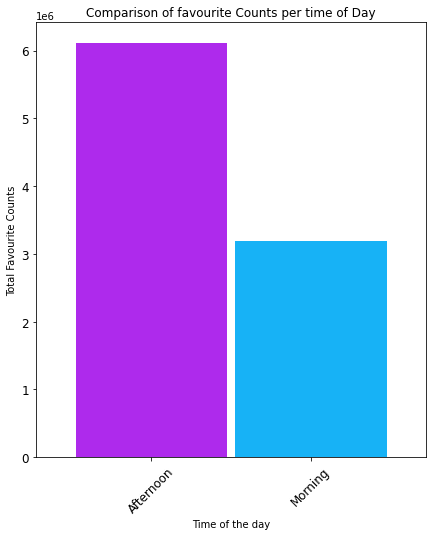

In [672]:
#Plot bar chart to visualize the time_diff findings

plt.figure(figsize = (7,8))
time_diff_bar= time_diff.plot.bar(xlabel='Time of the day', 
                                  color=['#AE2AEC', '#17B2F6'],
                                  ylabel='Total Favourite Counts', 
                                  title = 'Comparison of favourite Counts per time of Day',
                                  rot=45, 
                                  fontsize=12,
                                  width=0.95,
                                  grid=False
                                  
                             )

In [673]:
time_diff

timestamp
Afternoon    6110575.0
Morning      3189116.0
Name: favorite_count, dtype: float64

In [674]:
(time_diff.Afternoon - time_diff.Morning)/((time_diff.Afternoon + time_diff.Morning))*100

31.414581409210264

###### Insight 2.
Tweets sent out between 12:01PM and 11:59PM were favorited more than tweets sent out in the morning. 

##### Research Question 3. what is the most common dog name in the dataset?

In [675]:
#Count the occurrence of each name in the dataset

twitter_archive_master['name'].value_counts()

No_Name           687
incorrect_name    105
Charlie            11
Lucy               11
Oliver             10
Cooper             10
Penny               9
Tucker              9
Lola                8
Winston             8
Sadie               8
Daisy               7
Toby                7
Bailey              6
Jax                 6
Bella               6
Bo                  6
Stanley             6
Oscar               6
Koda                6
Milo                5
Buddy               5
Bentley             5
Leo                 5
Dave                5
Chester             5
Scout               5
Maggie              5
Rusty               5
Louis               5
Derek               4
Oakley              4
Jerry               4
Chip                4
Finn                4
Gary                4
Jeffrey             4
Winnie              4
Sophie              4
Archie              4
Duke                4
Brody               4
Scooter             4
George              4
Phil                4
Sammy     

In [676]:
#Total count of values in the name column

named = twitter_archive_master['name'].count()

In [677]:
#Number of unnamed dogs

unnamed = twitter_archive_master['name'].value_counts()['No_Name'] + twitter_archive_master['name'].value_counts()['incorrect_name']

In [678]:
'Unnamed dogs represented {:.2f}% of the total count, which was the highest portion of the sample'.format((unnamed/named) *100)

'Unnamed dogs represented 36.21% of the total count, which was the highest portion of the sample'

###### Insight 3:

The series object returned by the value_counts method indicates that the two items with the highest count were the unnamed dogs under the `no_name` and `incorrect_name` categories. The most common names after this category  were `Charlie` and `Lucy` which had a count of 11.  